In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="3"

Fri Jan 19 12:06:51 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   44C    P0    46W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.uniform_prior import Prior
from model.latent.blse_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [ ]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 3
hp.out_dim = 3
hp.z_dim = 128
hp.h_dims = [32, 64, 128, 256, 512]
hp.M = 1024
hp.N = 256
hp.const_sigma = False
hp.z_activation = F.tanh
hp.activation = F.sigmoid

''' Find Optimum Log-Sigma'''
from util.loglikelihood import get_optimum_log_sigma
from tqdm import tqdm

log_sigmas = []
for _ in tqdm(range(1000)):
    p_samples1 = (torch.rand(hp.M, 1)*2-1).cuda()
    p_samples2 = (torch.rand(hp.N, 1)*2-1).cuda()
    log_sigmas.append(get_optimum_log_sigma(p_samples1, p_samples2, -10, 10, temperature=1.0))
optimum_log_sigma = np.median(log_sigmas)
print(optimum_log_sigma)

hp.init_log_sigma = optimum_log_sigma

 12%|████▊                                   | 121/1000 [00:04<00:19, 44.14it/s]

In [ ]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

### Load

In [ ]:
save_dir = '/data/scpark/save/lse/train_celeba/train01.18-3e-3/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 1505, model_list, optimizer_list)

### Dataset

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

test_transforms = transforms.Compose([transforms.CenterCrop(148),
                                      transforms.Resize(hp.size),
                                      transforms.ToTensor(),])
test_dataset = MyCelebA(root, split='test', transform=test_transforms, download=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
print('done')

### Preprocess

In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=hp.M, temperature=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 3e-3
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            print(torch.exp(model_list[0].latent.log_sigma))
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=hp.M)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = model.prior.sample(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            corrcoef = torch.corrcoef(data['z_copy'].T).abs().data.cpu().numpy()
            # Plotting the matrix as a heatmap
            plt.figure(figsize=(10, 10))
            plt.imshow(corrcoef, cmap='viridis')
            plt.colorbar()
            plt.title('128x128 Matrix Heatmap')
            plt.show()
            
            corrcoef = np.mean(corrcoef * (1-np.eye(len(corrcoef))))
            writer.add_scalar('corrcoef', corrcoef, step)
            
            from util.mmd_penalty import mmd_penalty
            opts = {'pz_scale': 1,
                    'mmd_kernel': 'RBF', # 'IMQ', 'RBF'
                    'pz': 'normal', # 'normal', 'sphere', 'uniform' 
                    'zdim': hp.z_dim
                   } 
            e = (torch.rand_like(data['z_copy'])*2-1)
            mmd = mmd_penalty(data['z_copy'], e, opts).item()
            writer.add_scalar('MMD', mmd, step)
    
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

134273
lse_loss -0.6491866111755371
recon_loss 0.009840774349868298
134274
lse_loss -0.649607241153717
recon_loss 0.009698583744466305
134275
lse_loss -0.6520580053329468
recon_loss 0.008798646740615368
134276
lse_loss -0.6506272554397583
recon_loss 0.008411971852183342
134277
lse_loss -0.6452713012695312
recon_loss 0.009377831593155861
134278
lse_loss -0.6489427089691162
recon_loss 0.008570356294512749
134279
lse_loss -0.6504305005073547
recon_loss 0.009081248193979263
134280
lse_loss -0.6497443914413452
recon_loss 0.008837366476655006
134281
lse_loss -0.6489472389221191
recon_loss 0.009459177032113075
134282
lse_loss -0.6472967863082886
recon_loss 0.00793302059173584
134283
lse_loss -0.650519609451294
recon_loss 0.008630524389445782
134284
lse_loss -0.651540994644165
recon_loss 0.009024160914123058
134285
lse_loss -0.6473935842514038
recon_loss 0.008602489717304707
134286
lse_loss -0.6478458642959595
recon_loss 0.008876176550984383
134287
lse_loss -0.6475992202758789
recon_loss 0.008

134394
lse_loss -0.6509275436401367
recon_loss 0.0076157632283866405
134395
lse_loss -0.6505864858627319
recon_loss 0.009401185438036919
134396
lse_loss -0.6467557549476624
recon_loss 0.008517108857631683
134397
lse_loss -0.6478832364082336
recon_loss 0.009138114750385284
134398
lse_loss -0.6486729383468628
recon_loss 0.008777483366429806
134399
lse_loss -0.6499589681625366
recon_loss 0.00900910422205925
134400
lse_loss -0.6474297046661377
recon_loss 0.008104059845209122
134401
lse_loss -0.6502306461334229
recon_loss 0.00810583122074604
134402
lse_loss -0.6451563835144043
recon_loss 0.008454418741166592
134403
lse_loss -0.6451001167297363
recon_loss 0.00867003109306097
134404
lse_loss -0.648447573184967
recon_loss 0.009318001568317413
134405
lse_loss -0.6479849815368652
recon_loss 0.008174940012395382
134406
lse_loss -0.6515244245529175
recon_loss 0.008261704817414284
134407
lse_loss -0.6513283252716064
recon_loss 0.008266376331448555
134408
lse_loss -0.6507823467254639
recon_loss 0.01

In [31]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

done


tensor([0.0666], device='cuda:0', grad_fn=<ExpBackward0>)


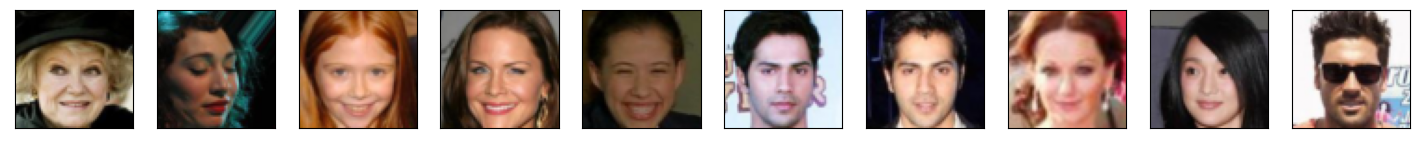

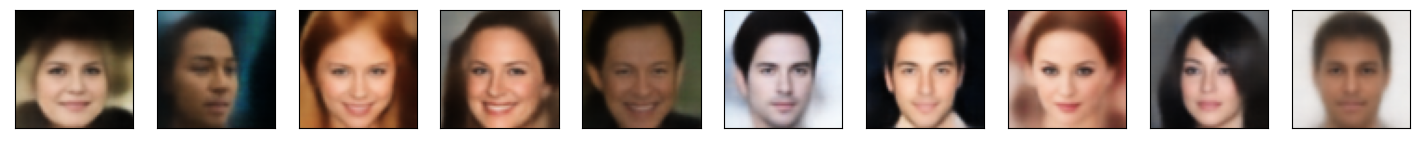

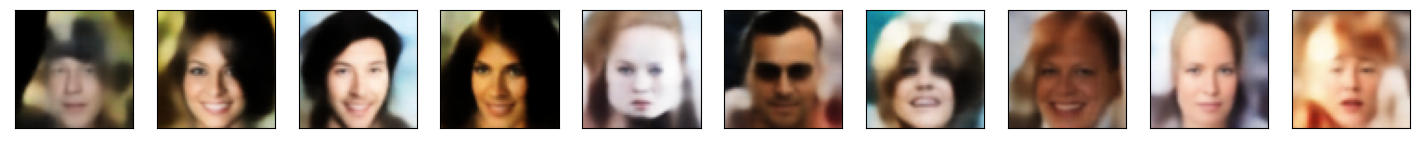

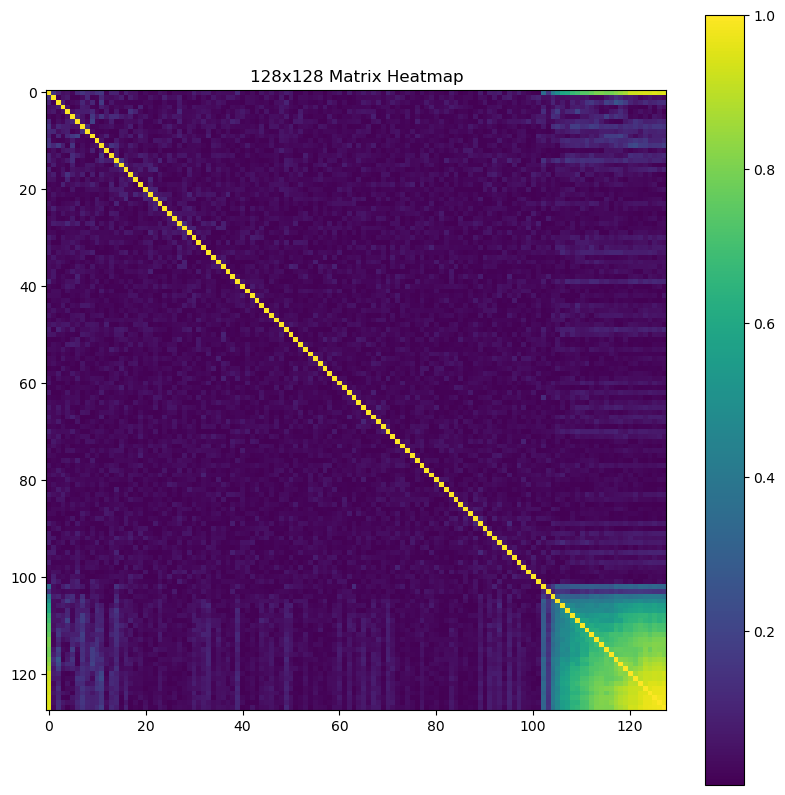

In [37]:
import matplotlib.pyplot as plt
display.clear_output()
print(torch.exp(model_list[0].latent.log_sigma))

batch = next(iter(test_loader))
data = preprocess(batch)

model = model_list[0]
model.eval()
with torch.no_grad():
    data = model(data, M=hp.M)

plot(data['x'])
plot(data['y'])

with torch.no_grad():
    z = model.prior.sample(10, hp.z_dim).to(device)
    y = model.sample(z)
    plot(y)

corrcoef = torch.corrcoef(data['z_copy'].T).abs().data.cpu().numpy()
# Plotting the matrix as a heatmap
plt.figure(figsize=(10, 10))
plt.imshow(corrcoef, cmap='viridis')
plt.colorbar()
plt.title('128x128 Matrix Heatmap')
plt.show()